In [24]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path(os.getcwd()).parent)
print(Path().cwd())

/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS
/Users/wuyuanshan/Desktop/Github


## Select Contrast-Enhanced Ultrasound (CEUS) Cine and Parser

In [25]:
from src.image_loading.options import get_scan_loaders

print("Available scan loaders:", list(get_scan_loaders().keys()))

Available scan loaders: ['avi', 'nifti', 'custom_dicom', 'mp4']


In [26]:
scan_type = 'nifti'

# Takes the DICOM file as input for contrast enhanced ultrasound (CEUS) scans
CEUS_scan_path = '/Volumes/T5 EVO/UCSD_3DCEUS/SIP/2025.08.19_P05V02/UCSD-P05-V02-CE1_09.45.08/UCSD-P05-V02-CE1_09.45.08_mf_sip_capture_50_2_1_0.raw_CEUS.nii.gz'
bmode_scan_path = '/Volumes/T5 EVO/UCSD_3DCEUS/SIP/2025.08.19_P05V02/UCSD-P05-V02-CE1_09.45.08/UCSD-P05-V02-CE1_09.45.08_mf_sip_capture_50_2_1_0.raw_BMODE.nii.gz'
scan_loader_kwargs = {
}

In [27]:
from src.entrypoints import scan_loading_step

image_data = scan_loading_step(scan_type, CEUS_scan_path, **scan_loader_kwargs)
bmode_image_data = scan_loading_step(scan_type, bmode_scan_path, **scan_loader_kwargs)

## Image Preprocessing

In [ ]:
from src.image_preprocessing.options import get_im_preproc_funcs, get_required_im_preproc_kwargs

print("Available preprocessing functions:", list(get_im_preproc_funcs().keys()))

In [ ]:
preproc_func_names = [] # in order of application
required_kwargs = get_required_im_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

In [ ]:
preproc_kwargs = {
    'target_vox_size': (1.0, 1.0, 1.0),
    'interp': 'linear',
}

In [ ]:
from src.entrypoints import scan_preprocessing_step

image_data = scan_preprocessing_step(preproc_func_names, image_data, **preproc_kwargs)

## Load Segmentation

Assumes same segmentation for each frame

In [28]:
from src.seg_loading.options import get_seg_loaders

print("Available segmentation loaders:", list(get_seg_loaders().keys()))

Available segmentation loaders: ['nifti', 'load_bolus_mask']


In [29]:
seg_type = 'nifti'

seg_path = '/Volumes/T5 EVO/UCSD_3DCEUS/SIP/2025.08.19_P05V02/UCSD-P05-V02-CE1_09.45.08/VOI_manual_seg.nii.gz'
seg_loader_kwargs = {}

In [30]:
from src.entrypoints import seg_loading_step

# Testing the motion compensation, right now is hard coded
seg_data = seg_loading_step(seg_type, image_data, seg_path, CEUS_scan_path, **seg_loader_kwargs)

The shape of the motion compensated mask is (147, 109, 110, 530)


(147, 109, 110, 530)


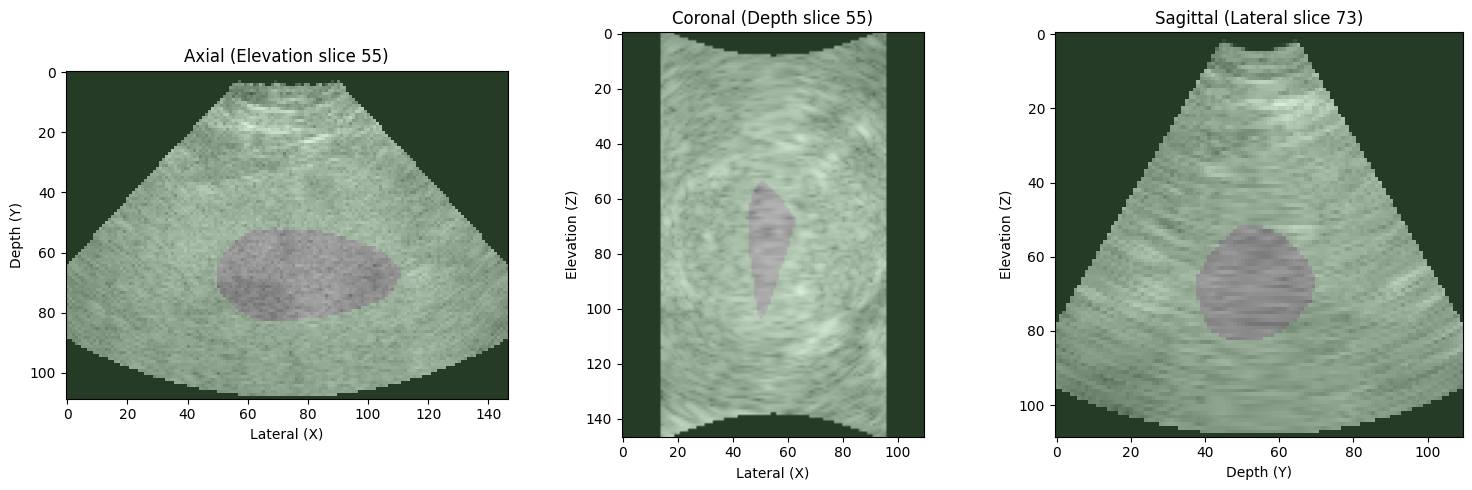

In [32]:
import matplotlib.pyplot as plt
import numpy as np
print(image_data.pixel_data.shape)


# Define slice positions
lateral_slice = 73  # x position
depth_slice = 55     # y position
elevation_slice = 55 # z position
frame = 10         # time point

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial view (looking down the elevation/z axis)
axes[0].imshow(np.transpose(bmode_image_data.pixel_data[:, :, elevation_slice, frame]), cmap='gray')
axes[0].imshow(np.transpose(seg_data.seg_mask[:, :, elevation_slice, frame]), cmap='Accent', alpha=0.3)
axes[0].set_title(f'Axial (Elevation slice {elevation_slice})')
axes[0].set_xlabel('Lateral (X)')
axes[0].set_ylabel('Depth (Y)')

# Coronal view (looking down the depth/y axis)
axes[1].imshow(bmode_image_data.pixel_data[:, depth_slice, :, frame], cmap='gray')
axes[1].imshow(seg_data.seg_mask[:, depth_slice, :, frame], cmap='Accent', alpha=0.3)
axes[1].set_title(f'Coronal (Depth slice {depth_slice})')
axes[1].set_xlabel('Lateral (X)')
axes[1].set_ylabel('Elevation (Z)')

# Sagittal view (looking down the lateral/x axis)
axes[2].imshow(bmode_image_data.pixel_data[lateral_slice, :, :, frame], cmap='gray')
axes[2].imshow(seg_data.seg_mask[lateral_slice, :, :, frame], cmap='Accent', alpha=0.3)
axes[2].set_title(f'Sagittal (Lateral slice {lateral_slice})')
axes[2].set_xlabel('Depth (Y)')
axes[2].set_ylabel('Elevation (Z)')

plt.tight_layout()
plt.show()

## Segmentation Preprocessing

In [8]:
from src.seg_preprocessing.options import get_seg_preproc_funcs, get_required_seg_preproc_kwargs

print("Available preprocessing functions:", list(get_seg_preproc_funcs().keys()))

Available preprocessing functions: ['resample', 'apply_motion_compensation', 'motion_compensation_3d', 'motion_compensation_3d_optical_flow']


In [10]:
preproc_func_names = ['motion_compensation_3d'] # in order of application
required_kwargs = get_required_seg_preproc_kwargs(preproc_func_names)
print("Required kwargs for preprocessing functions:", required_kwargs)

Required kwargs for preprocessing functions: ['search_margin_ratio', 'padding', 'bmode_image_data']


In [22]:
preproc_kwargs = {
    # For resampling
    # 'target_vox_size': (1.0, 1.0, 1.0),
    # 'interp': 'nearest',

    # For apply motion compensation function
    # 'motion_json_path':'/Users/wuyuanshan/Desktop/Github/CEUS_3D_MotionCompensation/motion_tracking_TJU-P02-V01-CEUS 2_10.43.42.json'

    # for motionc_compensation_3d
    'bmode_image_data': bmode_image_data,
    'padding': 3,
    'search_margin_ratio':0.5/30
    
}

In [21]:
from src.entrypoints import seg_preprocessing_step

seg_data = seg_preprocessing_step(preproc_func_names, image_data, seg_data, **preproc_kwargs)


3D Motion Compensation with ILSA Tracking

Step 1: Extracting bounding box from segmentation...
  Bounding box: Z=[142, 174], Y=[68, 98], X=[83, 118]
  Center: (np.float64(158.0), np.float64(83.0), np.float64(100.5))

Step 2: Tracking motion using ILSA...
  Reference frame: 0
  Search margin ratio: 0.016666666666666666
Tracking forward...
Tracking backward...

Tracking complete!
  Sources: {'reference': 18, 'previous': 17}
  Mean correlation: 0.474
  Min correlation: 0.113

Step 3: Applying motion compensation to segmentation...
  Frame 0: shift=(0.0, 0.0, 0.0), corr=1.000
  Frame 10: shift=(8.0, 0.0, -11.0), corr=0.262
  Frame 20: shift=(4.0, -2.0, -12.0), corr=0.325
  Frame 30: shift=(9.0, 0.0, -10.0), corr=0.229
  Frame 34: shift=(5.0, -3.0, -14.0), corr=0.927

Motion Compensation Complete!
  mc_seg_mask shape: (262, 193, 195, 35)
  Mean correlation: 0.474



## Visualizing Motion Compensated Results


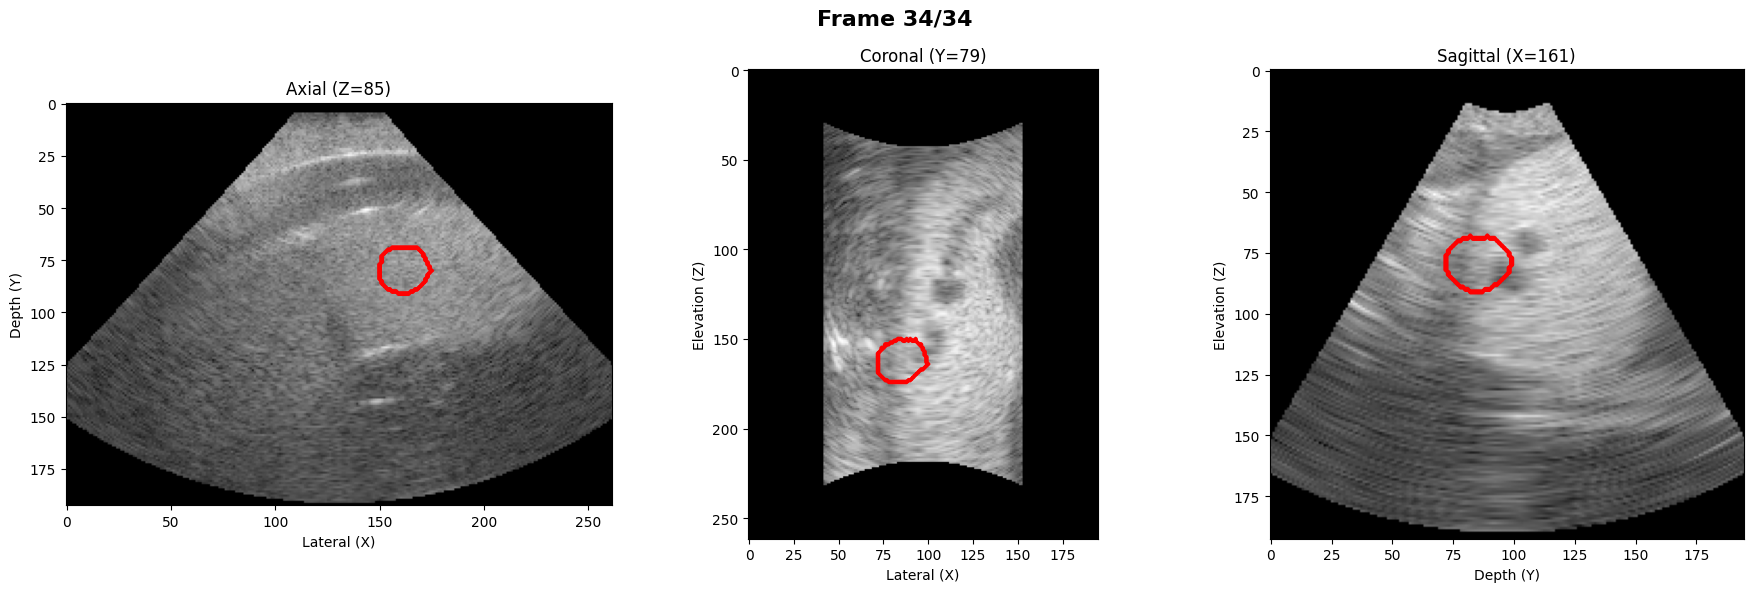

Frame 34/34

Animation complete!


In [23]:
# Use inline backend - MORE RELIABLE for Jupyter
%matplotlib inline

import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_erosion
import imageio
from PIL import Image
import io

def get_mask_boundary(mask_slice):
    """Extract boundary of a binary mask using erosion."""
    if mask_slice.max() == 0:
        return np.zeros_like(mask_slice, dtype=bool)
    eroded = binary_erosion(mask_slice)
    boundary = mask_slice.astype(bool) & ~eroded
    return boundary

def get_voi_center(mask_3d):
    """Calculate the center of a 3D VOI mask."""
    coords = np.where(mask_3d > 0)
    if len(coords[0]) == 0:
        return None, None, None
    lateral_center = int(np.mean(coords[0]))
    depth_center = int(np.mean(coords[1]))
    elevation_center = int(np.mean(coords[2]))
    return lateral_center, depth_center, elevation_center

print(f"Image shape: {image_data.pixel_data.shape}")
print(f"Mask shape: {seg_data.seg_mask.shape}")

# Define slice positions
lateral_slice = 160
depth_slice = 85
elevation_slice = 100

# Frame range
num_frames = image_data.pixel_data.shape[3]
start_frame = 0
end_frame = min(num_frames, 300)

print(f"Visualizing frames {start_frame} to {end_frame}")
print("Starting animation...\n")

MC_flag = True  # Set to True to visualize motion compensated mask

# Loop through frames
for frame in range(start_frame, end_frame):
    # Clear previous output and display current frame
    clear_output(wait=True)

    if MC_flag:
        mask = seg_data.mc_seg_mask
    else:
        mask = seg_data.seg_mask
    # Calculate VOI center for this specific frame
    lateral_slice, depth_slice, elevation_slice = get_voi_center(mask[:, :, :, frame])
    
    if lateral_slice is None:
        print(f"Warning: No VOI found in frame {frame}, skipping...")
        continue
    
    # Create figure for this frame
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # === AXIAL VIEW ===
    axial_img = np.transpose(bmode_image_data.pixel_data[:, :, elevation_slice, frame])
    axial_mask = np.transpose(mask[:, :, elevation_slice, frame])
    axial_boundary = get_mask_boundary(axial_mask)
    
    axes[0].imshow(axial_img, cmap='gray')
    axes[0].contour(axial_boundary, colors='red', linewidths=2)
    axes[0].set_title(f'Axial (Z={elevation_slice})')
    axes[0].set_xlabel('Lateral (X)')
    axes[0].set_ylabel('Depth (Y)')
    
    # === CORONAL VIEW ===
    coronal_img = bmode_image_data.pixel_data[:, depth_slice, :, frame]
    coronal_mask = mask[:, depth_slice, :, frame]
    coronal_boundary = get_mask_boundary(coronal_mask)
    
    axes[1].imshow(coronal_img, cmap='gray')
    axes[1].contour(coronal_boundary, colors='red', linewidths=2)
    axes[1].set_title(f'Coronal (Y={depth_slice})')
    axes[1].set_xlabel('Lateral (X)')
    axes[1].set_ylabel('Elevation (Z)')
    
    # === SAGITTAL VIEW ===
    sagittal_img = bmode_image_data.pixel_data[lateral_slice, :, :, frame]
    sagittal_mask = mask[lateral_slice, :, :, frame]
    sagittal_boundary = get_mask_boundary(sagittal_mask)
    
    axes[2].imshow(sagittal_img, cmap='gray')
    axes[2].contour(sagittal_boundary, colors='red', linewidths=2)
    axes[2].set_title(f'Sagittal (X={lateral_slice})')
    axes[2].set_xlabel('Depth (Y)')
    axes[2].set_ylabel('Elevation (Z)')
    
    # Add overall frame counter
    fig.suptitle(f'Frame {frame}/{end_frame-1}', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print progress
    print(f"Frame {frame}/{end_frame-1}")
    
    # Pause
    time.sleep(0.1)
    
    # Close figure to save memory
    plt.close(fig)

print("\nAnimation complete!")

In [ ]:
%matplotlib inline

print(f"Image shape: {image_data.pixel_data.shape}")
print(f"Mask shape: {seg_data.seg_mask.shape}")

# Frame range
num_frames = image_data.pixel_data.shape[3]
start_frame = 0
end_frame = min(num_frames, 300)

print(f"Creating GIF for frames {start_frame} to {end_frame}")

# List to store frames
frames = []

# Loop through frames and save each as an image
for frame in range(start_frame, end_frame):
    # Calculate VOI center for this specific frame
    lateral_slice, depth_slice, elevation_slice = get_voi_center(seg_data.mc_seg_mask[:, :, :, frame])
    
    if lateral_slice is None:
        print(f"Warning: No VOI found in frame {frame}, skipping...")
        continue
    
    # Create figure for this frame
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # === AXIAL VIEW ===
    axial_img = np.transpose(image_data.pixel_data[:, :, elevation_slice, frame])
    axial_mask = np.transpose(seg_data.mc_seg_mask[:, :, elevation_slice, frame])
    axial_boundary = get_mask_boundary(axial_mask)
    
    axes[0].imshow(axial_img, cmap='gray')
    axes[0].contour(axial_boundary, colors='red', linewidths=2)
    axes[0].set_title(f'Axial (Z={elevation_slice})')
    axes[0].set_xlabel('Lateral (X)')
    axes[0].set_ylabel('Depth (Y)')
    
    # === CORONAL VIEW ===
    coronal_img = image_data.pixel_data[:, depth_slice, :, frame]
    coronal_mask = seg_data.mc_seg_mask[:, depth_slice, :, frame]
    coronal_boundary = get_mask_boundary(coronal_mask)
    
    axes[1].imshow(coronal_img, cmap='gray')
    axes[1].contour(coronal_boundary, colors='red', linewidths=2)
    axes[1].set_title(f'Coronal (Y={depth_slice})')
    axes[1].set_xlabel('Lateral (X)')
    axes[1].set_ylabel('Elevation (Z)')
    
    # === SAGITTAL VIEW ===
    sagittal_img = image_data.pixel_data[lateral_slice, :, :, frame]
    sagittal_mask = seg_data.mc_seg_mask[lateral_slice, :, :, frame]
    sagittal_boundary = get_mask_boundary(sagittal_mask)
    
    axes[2].imshow(sagittal_img, cmap='gray')
    axes[2].contour(sagittal_boundary, colors='red', linewidths=2)
    axes[2].set_title(f'Sagittal (X={lateral_slice})')
    axes[2].set_xlabel('Depth (Y)')
    axes[2].set_ylabel('Elevation (Z)')
    
    # Add overall frame counter with VOI center info
    fig.suptitle(f'Frame {frame}/{end_frame-1} | VOI Center: X={lateral_slice}, Y={depth_slice}, Z={elevation_slice}', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    
    # Convert figure to image array
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    frames.append(np.array(img))
    
    plt.close(fig)
    buf.close()
    
    # Print progress
    if frame % 10 == 0:
        print(f"Processing frame {frame}/{end_frame-1} | VOI center: X={lateral_slice}, Y={depth_slice}, Z={elevation_slice}")

# Save as GIF
output_filename = '/Users/wuyuanshan/Desktop/Github/QuantUS-Plugins-CEUS/CLI-Demos/voi_with_mc.gif'
imageio.mimsave(output_filename, frames, fps=10, loop=0)

print(f"\nGIF saved as: {output_filename}")
print(f"Total frames: {len(frames)}")

## CEUS Quantitative Temporal Curve Analysis

In [ ]:
from src.time_series_analysis.options import get_analysis_types, get_required_kwargs

all_analysis_types, all_analysis_funcs = get_analysis_types()
print("Available analysis types:", list(all_analysis_types.keys()))

In [ ]:
analysis_type = 'curves'

print("Available analysis functions:", list(all_analysis_funcs.keys()))

In [ ]:
analysis_funcs = ['tic']

# Find all required kwargs for the analysis functions
analysis_funcs = analysis_funcs if len(analysis_funcs) else list(all_analysis_funcs[analysis_type].keys())
required_kwargs = get_required_kwargs(analysis_type, analysis_funcs)
print("Required kwargs for current analysis:", required_kwargs)

In [ ]:
analysis_kwargs = {
    # 'pyradiomics_config_paths': [
    #     '/home/das/QuantUS_Projs/QuantUS-Plugins-CEUS/configs/pyradiomics/moderate-pselectin.yml',
    # ],
    # 'curves_output_path': 'test2.csv',
    # 'binwidth': 25,
    # 'min_intensity': 0,
}

In [ ]:
image_data.intensities_for_analysis.shape
print(seg_data.use_mc)

In [ ]:
from src.entrypoints import analysis_step

analysis_obj = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

In [ ]:
seg_data.use_mc = False
print(seg_data.use_mc)

In [ ]:
from src.entrypoints import analysis_step

analysis_obj_wo_mc = analysis_step(analysis_type, image_data, seg_data, analysis_funcs, **analysis_kwargs)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a specific size (e.g., 8 inches wide, 6 inches tall)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(analysis_obj.time_arr,analysis_obj.curves[0]['TIC'], label='Motion Compensated')
ax.plot(analysis_obj_wo_mc.time_arr,analysis_obj_wo_mc.curves[0]['TIC'], label='Without Motion Compensation')

ax.set_xlabel('Time (s)')
ax.set_ylabel('TIC')
ax.set_title('TIC Over Time')
ax.legend()

plt.show()

## Curve Quantification

In [ ]:
from src.curve_quantification.options import get_quantification_funcs

quantification_funcs = get_quantification_funcs()
print("Available quantification functions:", quantification_funcs.keys())

In [ ]:
function_names = ['dte'] # Empty list will use all functions
output_path = 'test_quants.csv'
curve_quantifications_kwargs = {
    'curves_to_fit': ['moderate-pselectin_diagnostics_Image-original_Mean'],
    'n_frames_to_analyze': 100,
    'tic_name': 'TIC'
}

In [ ]:
from src.entrypoints import curve_quantification_step

curve_quant = curve_quantification_step(analysis_obj, function_names, output_path, **curve_quantifications_kwargs)